# 2. Preprocessing & Feature Engineering

In this notebook there are a series of decisions and transformations that needs to be executed before moving on to modeling.

- Standardize column names (strip spaces, lower-case, replace spaces).
- Drop ID column and any bookkeeping cols.
- Ensure target is 0/1 int and cast types.
- Split data first (train / test / optional val) with stratify=churn.
- Handle multicollinearity (VIF / drop or combine correlated features) using train data only.
- Run a quick baseline model (logistic + random forest) to validate preprocessing choices.
- Apply resampling (SMOTE/oversample/undersample) only on the training set.
- Handle skew / outliers (log/boxcox, clipping) using parameters fitted on train.
- Encode categoricals (ordered mapping for Age/Charge, one-hot or target encoding).
- Scale numeric features (StandardScaler / MinMax) as part of pipeline.
- Persist preprocessing artifacts (scaler, encoders) and document decisions.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [2]:
churn_data = pd.read_csv('Customer Churn.csv')
churn_data.head()

,Call Failure,Complains,Subscription Length,Charge Amount,Seconds of Use,Frequency of use,Frequency of SMS,Distinct Called Numbers,Age Group,Tariff Plan,Status,Age,Customer Value,Churn
0,8,0,38,0,4370,71,5,17,3,1,1,30,197.640,0
1,0,0,39,0,318,5,7,4,2,1,2,25,46.035,0
2,10,0,37,0,2453,60,359,24,3,1,1,30,1536.520,0
3,10,0,38,0,4198,66,1,35,1,1,1,15,240.020,0
4,3,0,38,0,2393,58,2,33,1,1,1,15,145.805,0


### Standrizing column names

In [3]:
# Standardize column names + basic checks
print(churn_data.columns)
churn_data.columns = (churn_data.columns
                      .str.strip()
                      .str.replace(r'\s+', ' ', regex=True)
                      .str.replace(' ', '_')
                      .str.lower())
print(churn_data.columns)

Index(['Call  Failure', 'Complains', 'Subscription  Length', 'Charge  Amount',
       'Seconds of Use', 'Frequency of use', 'Frequency of SMS',
       'Distinct Called Numbers', 'Age Group', 'Tariff Plan', 'Status', 'Age',
       'Customer Value', 'Churn'],
      dtype='object')
Index(['call_failure', 'complains', 'subscription_length', 'charge_amount',
       'seconds_of_use', 'frequency_of_use', 'frequency_of_sms',
       'distinct_called_numbers', 'age_group', 'tariff_plan', 'status', 'age',
       'customer_value', 'churn'],
      dtype='object')


### Dropping unnecessary columns
- The `ID` column is already dropped.
- Drop the `age_group` since we already have the `age` column.
- Ensuring that `churn` column is binary.

In [4]:
# drop age_group column
churn_data = churn_data.drop(columns=['age_group'])
print(churn_data.columns)

Index(['call_failure', 'complains', 'subscription_length', 'charge_amount',
       'seconds_of_use', 'frequency_of_use', 'frequency_of_sms',
       'distinct_called_numbers', 'tariff_plan', 'status', 'age',
       'customer_value', 'churn'],
      dtype='object')


In [5]:
# making sure that the target is binary
churn_data['churn'].value_counts()

churn
0    2655
1     495
Name: count, dtype: int64

### Splitting the data

In [6]:
train_data, test_data = train_test_split(churn_data, test_size=0.2, random_state=13, stratify=churn_data['churn'])

In [7]:
len(train_data), len(test_data)

(2520, 630)

### Checking for Multicollinearity

In [8]:
# VIF check (use train numeric columns)
from statsmodels.stats.outliers_influence import variance_inflation_factor
num_cols = train_data.select_dtypes(include='number').columns.drop('churn')
X = train_data[num_cols].fillna(0)
vif = pd.Series([variance_inflation_factor(X.values, i) for i in range(X.shape[1])], index=X.columns)
print(vif.sort_values(ascending=False))

customer_value             92.251337
frequency_of_sms           56.836990
seconds_of_use             47.348389
frequency_of_use           45.383999
age                        20.231720
tariff_plan                18.944151
status                     15.348647
subscription_length        15.065965
distinct_called_numbers     6.782807
call_failure                6.111320
charge_amount               4.217802
complains                   1.253891
dtype: float64


This was really expected since we already saw high correlation between some features while exploring the data in [01_data_exploration](01_data_exploration.ipynb).

This result is screaming for an action. Specially, because we would like to use **Logistic Regression** which is heavily influenced by **Multicollinearity**.

So, let's take the top 5 and examine them closely.

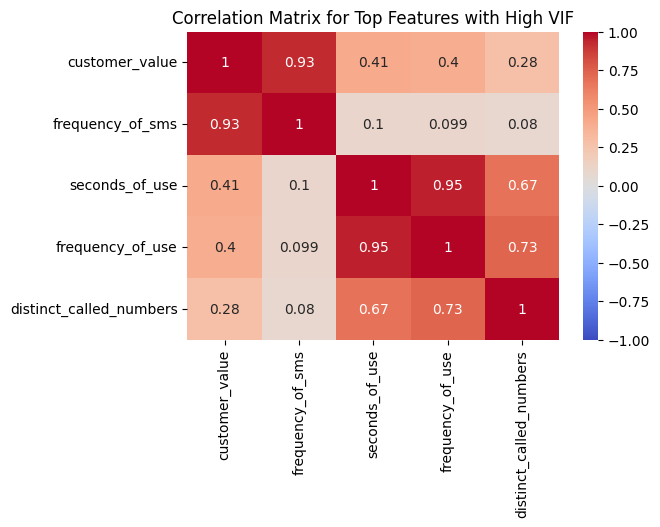

In [9]:
# 1. show pairwise correlations for top cols
top = ['customer_value','frequency_of_sms','seconds_of_use','frequency_of_use','distinct_called_numbers']
plt.figure(figsize=(6,4))
sns.heatmap(train_data[top].corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix for Top Features with High VIF')
plt.show()

As we can see there, there is pretty high correlation. We can either remove redundant features or combine them into one feature.

In [10]:
# 2) create avg_call_duration and sms_per_call, handle zeros
train_data_new_features = train_data.copy()
train_data_new_features['avg_call_duration'] = train_data_new_features['seconds_of_use'] / train_data_new_features['frequency_of_use'].replace(0, np.nan)
train_data_new_features['sms_per_call'] = train_data_new_features['frequency_of_sms'] / train_data_new_features['frequency_of_use'].replace(0, np.nan)

# 3) drop or temporarily disable highly redundant raw cols (test effect)
train_vif_cols = train_data_new_features.select_dtypes(include='number').columns.drop('churn').tolist()
# e.g., drop frequency_of_sms and seconds_of_use to test
candidate_drop = ['frequency_of_sms','seconds_of_use'] 
train_vif_test = train_data_new_features[train_vif_cols].drop(columns=[c for c in candidate_drop if c in train_vif_cols]).fillna(0)

vif_test = pd.Series([variance_inflation_factor(train_vif_test.values, i)
                      for i in range(train_vif_test.shape[1])],
                     index=train_vif_test.columns).sort_values(ascending=False)
print("VIF after dropping candidates:\n", vif_test)

VIF after dropping candidates:
 status                     15.071320
subscription_length        14.611874
tariff_plan                13.927704
age                        13.449498
frequency_of_use            9.421654
distinct_called_numbers     6.618584
customer_value              6.449337
call_failure                5.505161
avg_call_duration           4.563185
sms_per_call                3.480605
charge_amount               3.135795
complains                   1.253828
dtype: float64


Although the VIF is still relatively high this is a huge improvement to our features

In [11]:
train_data_new_features.head()

,call_failure,complains,subscription_length,charge_amount,seconds_of_use,frequency_of_use,frequency_of_sms,distinct_called_numbers,tariff_plan,status,age,customer_value,churn,avg_call_duration,sms_per_call
1731,0,0,34,0,513,2,11,5,1,2,45,40.375,1,256.500000,5.500000
449,1,0,6,1,1308,11,0,2,1,1,30,52.760,1,118.909091,0.000000
2168,8,0,41,2,365,9,12,4,1,1,30,62.960,1,40.555556,1.333333
832,2,0,41,2,338,10,12,3,1,1,55,23.220,0,33.800000,1.200000
1351,0,0,31,0,0,0,0,0,1,2,25,0.000,0,NaN,NaN


### Testing the old and new features using **Logistic Regression**

In [12]:
# Quick CV comparison: logistic (L2) vs random forest (roc_auc)
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

y = train_data_new_features['churn']
X_full = train_data_new_features.drop(columns=['churn']).fillna(0)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
lr = LogisticRegression(max_iter=2000, solver='liblinear', penalty='l2', C=1.0)
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

print("LR ROC-AUC:", cross_val_score(lr, X_full, y, cv=cv, scoring='roc_auc').mean())
print("RF  ROC-AUC:", cross_val_score(rf, X_full, y, cv=cv, scoring='roc_auc').mean())

LR ROC-AUC: 0.9282040744109918
RF  ROC-AUC: 0.9850855567477769


In [13]:
# Quick CV comparison: logistic (L2) vs random forest (roc_auc)
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

y = train_data['churn']
X_full = train_data.drop(columns=['churn']).fillna(0)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
lr = LogisticRegression(max_iter=2000, solver='liblinear', penalty='l2', C=1.0)
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

print("LR ROC-AUC:", cross_val_score(lr, X_full, y, cv=cv, scoring='roc_auc').mean())
print("RF  ROC-AUC:", cross_val_score(rf, X_full, y, cv=cv, scoring='roc_auc').mean())

LR ROC-AUC: 0.9252764122845221
RF  ROC-AUC: 0.9836038758798242


In [14]:
train_data.head()

,call_failure,complains,subscription_length,charge_amount,seconds_of_use,frequency_of_use,frequency_of_sms,distinct_called_numbers,tariff_plan,status,age,customer_value,churn
1731,0,0,34,0,513,2,11,5,1,2,45,40.375,1
449,1,0,6,1,1308,11,0,2,1,1,30,52.760,1
2168,8,0,41,2,365,9,12,4,1,1,30,62.960,1
832,2,0,41,2,338,10,12,3,1,1,55,23.220,0
1351,0,0,31,0,0,0,0,0,1,2,25,0.000,0
